## Loading Sharadar SEP and Daily Bundles for Running the Zipline Pipeline

The notebook demonstrates and tests the interface for running the Zipline open-source research platform with two Sharadar data bundles, daily prices and fundamentals (ingested with the corresponding notebooks within this repository). This example consists of six steps: (1) building the pipeline engine, (2) building pipeline, (3) running it, (4) reading the Sharadar files for comparison with pipeline output, (5) unadjusting Sharadar split-adjusted prices and merging them with daily fundamentals, (6) and testing the pipeline data.

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Importing the fsharadar.sep and fsharadar.daily modules from the Flounder extension

In [2]:
from fsharadar import sep
from fsharadar import daily

## 1. Building Pipeline Engine

Loading Sharadar bundles

In [3]:
sep_bundle_data = sep.load()
daily_bundle_data = daily.load()

Combining bundle-specific pipeline loaders

In [4]:
from zipline.pipeline.data import USEquityPricing

sep_pipe_loader = sep.PipelineLoader(sep_bundle_data)
daily_pipe_loader = daily.PipelineLoader(daily_bundle_data)

def get_pipe_loader(column):
    if column in USEquityPricing.columns:
        return sep_pipe_loader
    if column in daily.Fundamentals.columns:
        return daily_pipe_loader
    raise ValueError("No PipelineLoader registered for column %s." % column)

Selecting pipeline asset_finder

In [5]:
pipe_asset_finder = sep_bundle_data.asset_finder

Defining the Zipline pipeline engine

In [6]:
from zipline.pipeline.engine import SimplePipelineEngine

engine = SimplePipelineEngine(
    get_loader=get_pipe_loader,
    asset_finder=pipe_asset_finder,
)

## 2. Building Pipeline

Reviewing characteristics of the bundle-specific data sets

In [7]:
USEquityPricing.columns

frozenset({EquityPricing<US>.close::float64,
           EquityPricing<US>.currency::object,
           EquityPricing<US>.high::float64,
           EquityPricing<US>.low::float64,
           EquityPricing<US>.open::float64,
           EquityPricing<US>.volume::float64})

In [8]:
daily.Fundamentals.columns

frozenset({FundamentalsDataSet<US>.currency::object,
           FundamentalsDataSet<US>.ev::float64,
           FundamentalsDataSet<US>.evebit::float64,
           FundamentalsDataSet<US>.evebitda::float64,
           FundamentalsDataSet<US>.marketcap::float64,
           FundamentalsDataSet<US>.pb::float64,
           FundamentalsDataSet<US>.pe::float64,
           FundamentalsDataSet<US>.ps::float64})

Selecting common assets

In [9]:
sep_asset_finder = sep_bundle_data.asset_finder
sep_assets = sep_asset_finder.retrieve_all(sep_asset_finder.sids)

daily_asset_finder = daily_bundle_data.asset_finder
daily_assets = daily_asset_finder.retrieve_all(daily_asset_finder.sids)

common_assets = list(set(sep_assets) &  set(daily_assets))

print(len(sep_assets), len(daily_assets), len(common_assets))

11663 9266 9161


Combining columns and screen within one pipeline

In [10]:
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline import Pipeline

pipe = Pipeline(
    columns={
        'close': USEquityPricing.close.latest,
        'high': USEquityPricing.high.latest,  
        'low': USEquityPricing.low.latest,   
        'open': USEquityPricing.open.latest,  
        'volume': USEquityPricing.volume.latest, 
        'ev': daily.Fundamentals.ev.latest,
        'evebit': daily.Fundamentals.evebit.latest,  
        'evebitda': daily.Fundamentals.evebitda.latest,   
        'marketcap': daily.Fundamentals.marketcap.latest,  
        'pb': daily.Fundamentals.pb.latest, 
        'pe': daily.Fundamentals.pe.latest,   
        'ps': daily.Fundamentals.ps.latest, 
    },
    screen=StaticAssets(common_assets)
)

## 3. Running Pipeline

In [11]:
start_date = "2010-12-31"; end_date = "2021-02-12"

In [12]:
%%time
pipe_df = engine.run_pipeline(
    pipe,
    pd.Timestamp(start_date, tz='utc'),
    pd.Timestamp(end_date, tz='utc')
)

CPU times: user 25.7 s, sys: 7.43 s, total: 33.2 s
Wall time: 20.7 s


In [13]:
pipe_df.head(2)

close    ev  evebit  \
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])   0.01  18.4    -9.4   
                          Equity(101512 [GOVB])    9.25  42.2    28.3   

                                                  evebitda  high   low  \
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])     -34.5  0.01  0.01   
                          Equity(101512 [GOVB])       26.2  9.25  9.25   

                                                  marketcap  open   pb    pe  \
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])        0.0  0.01  0.0   0.0   
                          Equity(101512 [GOVB])        21.3  9.25  1.0  21.8   

                                                   ps  volume  
2011-01-04 00:00:00+00:00 Equity(101501 [BBUCQ])  0.0     0.0  
                          Equity(101512 [GOVB])   4.4     0.0

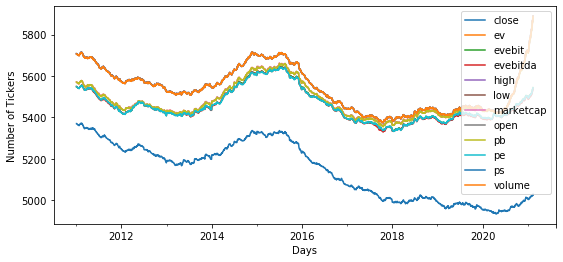

In [14]:
pipe_df.groupby(level=0).count().plot(figsize=(9, 4))
plt.xlabel('Days')
plt.ylabel('Number of Tickers')
plt.show()

In [15]:
len(pipe_df.index.get_level_values(1).unique())

9149

## 4. Loading Sharadar files for Testing Pipeline Data

### 4.1 Tickers (with associated sids) 

In [16]:
sharadar_tickers_file = "./SHARADAR_TICKERS.csv"

In [17]:
%%time
tickers_df = pd.read_csv(sharadar_tickers_file)
all_tickers = tickers_df.ticker.unique()
print(len(all_tickers))

23794
CPU times: user 200 ms, sys: 2.75 ms, total: 203 ms
Wall time: 222 ms


### 4.2 Sharadar Equity Prices (SEP) and Actions (including splits)

SEP (Sharadar Equity Prices) 

In [18]:
sharadar_sep_file = "./SHARADAR_SEP.csv"

In [19]:
%%time
from fsharadar.sep.ingest import read_sep_file

sep_df = read_sep_file(sharadar_sep_file, tickers_df)
sep_tickers = sep_df.symbol.unique()
print(len(sep_tickers))

11667
CPU times: user 18.7 s, sys: 822 ms, total: 19.6 s
Wall time: 20.3 s


Actions

In [20]:
actions_file = "./SHARADAR_ACTIONS.csv"

In [21]:
%%time

from fsharadar.sep.ingest import read_actions_file

# read actions_file (with splits)
actions_df = read_actions_file(actions_file, tickers_df)

CPU times: user 270 ms, sys: 0 ns, total: 270 ms
Wall time: 288 ms


### 4.3 Daily Metrics of Sharadar Fundamental Data

In [22]:
sharadar_daily_file = "./SHARADAR_DAILY.csv"

In [23]:
%%time
from fsharadar.daily.ingest import read_daily_file

daily_df = read_daily_file(sharadar_daily_file, tickers_df)
daily_tickers = daily_df.symbol.unique()
print(len(daily_tickers))

9266
CPU times: user 14.4 s, sys: 918 ms, total: 15.3 s
Wall time: 16.1 s


## 5. Unadjusting SEP Data and  Merging Them with  Daily Metrics

Unadjusting the Sharadar split-adjusted prices

In [24]:
%%time

from fsharadar.sep.ingest import unadjust_splits

sep_df = unadjust_splits(sep_df, actions_df)
sep_tickers = sep_df.symbol.unique()
print(len(sep_tickers))

11663
CPU times: user 1min 34s, sys: 1.05 s, total: 1min 35s
Wall time: 1min 35s


Selecting common SEP and Daily tickers

In [25]:
common_tickers = list(set(sep_tickers) &  set(daily_tickers))
len(common_tickers)

9161

In [26]:
%%time
sep_df = sep_df.query('symbol in @common_tickers')

CPU times: user 656 ms, sys: 116 ms, total: 772 ms
Wall time: 753 ms


In [27]:
%%time
daily_df = daily_df.query('symbol in @common_tickers')

CPU times: user 899 ms, sys: 121 ms, total: 1.02 s
Wall time: 1 s


Merging SEP and Daily dataframes

In [28]:
sep_df = sep_df.merge(daily_df, how='left', on=['symbol', 'date'], )
combo_tickers = sep_df.symbol.unique()
print(len(combo_tickers))

9161


Transforming into multi-index (pipeline-like) dataframe

In [29]:
sep_df = sep_df.set_index(['date', 'symbol'])

In [30]:
%%time
sep_df.sort_index(level=0, inplace=True)

CPU times: user 8.91 s, sys: 735 ms, total: 9.65 s
Wall time: 9.64 s


In [31]:
sep_df.head(2)

open   high     low  close     volume  dividends       ev  \
date       symbol                                                               
2011-01-03 A       41.56  42.14  41.411  41.88  3572300.0        0.0  14043.7   
           AACC     5.99   6.25   5.990   6.15    20400.0        0.0    358.2   

                   evebit  evebitda  marketcap   pb    pe   ps  
date       symbol                                               
2011-01-03 A         17.8      14.2    14557.7  4.5  21.3  2.7  
           AACC     -16.5     -20.9      188.3  1.4 -12.7  1.1

## 6. Testing pipeline data

### 6.1 Explaining the difference set between the pipeline and file assets

Identifying the difference set

In [33]:
pipe_assets = pipe_df.index.get_level_values(1).unique()
pipe_tickers = [asset.symbol for asset in pipe_assets]
raw_tickers = sep_df.index.get_level_values(1).unique()
diff_tickers = set(raw_tickers) - set(pipe_tickers)
print(len(diff_tickers))

12


Showing that the pipeline excludes assets containing only one data point

In [34]:
tag_name = sep.bundle_tags[0]

raw_tag_df = sep_df[tag_name].unstack() 
raw_tag_df = raw_tag_df.loc[start_date: end_date]

for i, ticker in enumerate(diff_tickers):
    asset_raw_ts = raw_tag_df[ticker].dropna()
    print(i, ticker, 'size:', asset_raw_ts.size)

0 LGVN size: 1
1 TLIS size: 1
2 CVII.U size: 1
3 DBTX size: 1
4 TSIBU size: 1
5 SLAC.U size: 1
6 CHAA.U size: 1
7 CCVI.U size: 1
8 RCLFU size: 1
9 SCLEU size: 1
10 TCACU size: 1
11 NEXI size: 1


### 6.2 Comparing the lengths of the asset time series produced from pipeline and Sharadar files

The following script shows that the lengths of the time series are the same with the exception of one asset (LOV), due to pipeline interpolation.

In [35]:
%%time

tag_name = daily.bundle_tags[0]

raw_tag_df = sep_df[tag_name].unstack() 
raw_tag_df = raw_tag_df.loc[start_date: end_date]

pipe_tag_df = pipe_df[tag_name].unstack()
pipe_tag_assets = pipe_tag_df.columns.values

for i, asset in enumerate(pipe_tag_assets):
        
    ticker = asset.symbol
    asset_raw_ts = raw_tag_df[ticker].dropna()
    asset_pipe_ts = pipe_tag_df[asset].dropna() 
        
    if asset_pipe_ts.size > asset_raw_ts.size:
        print(i, ticker, 'interpolation:', asset_pipe_ts.size, '>', asset_raw_ts.size)
        continue

5111 LOV interpolation: 822 > 818
CPU times: user 6.64 s, sys: 882 ms, total: 7.52 s
Wall time: 7.52 s


### 6.3 Checking for potential differences in asset time series

The following code runs through all the SEP and Daily bundle characteristics and for each ticker checks for potential discrepencies between the time series from Zipline pipeline and Sharadar file. 

In [36]:
def check_assets(pipe_tag_df, raw_tag_df):
    
    pipe_tag_tickers = pipe_tag_df.columns.values

    for i, asset in enumerate(pipe_tag_tickers):
        
        ticker = asset.symbol
        asset_raw_ts = raw_tag_df[ticker].dropna()
        
        asset_pipe_ts = pipe_tag_df[asset].dropna() 
        
        if asset_pipe_ts.size > asset_raw_ts.size:
            continue

        # PipelineReader shifted data 'that would
        # be known at the **start** of each date'
        
        size = min(asset_raw_ts.size, asset_pipe_ts.size)
        if size < asset_raw_ts.size - 1:
            print(i, ticker, size, asset_raw_ts.size, asset_pipe_ts.size)
            
        std_diff = np.std(asset_raw_ts.values[:size] - asset_pipe_ts.values[:size])
    
        if np.abs(std_diff) > 1.e-4 :
            print(i, ticker, std_diff)

In [39]:
for i, tag_name in enumerate(sep.bundle_tags + daily.bundle_tags):
    start = time.time()
    pipe_tag_df = pipe_df[tag_name].unstack()
    raw_tag_df = sep_df[tag_name].unstack() 
    raw_tag_df = raw_tag_df.loc[start_date: end_date]
    check_assets(pipe_tag_df, raw_tag_df)
    end = time.time()
    print(i, tag_name, ', processing time:', end - start)

0 close , processing time: 8.17440938949585
1 high , processing time: 8.26007866859436
2 low , processing time: 8.240079402923584
3 open , processing time: 8.296991109848022
4 volume , processing time: 8.326128721237183
5 marketcap , processing time: 8.502599954605103
6 ev , processing time: 8.751691818237305
7 evebit , processing time: 8.53484296798706
8 evebitda , processing time: 8.201447486877441
9 pb , processing time: 8.19950819015503
10 pe , processing time: 8.397982358932495
11 ps , processing time: 8.299079418182373
